# Lab 7: Convolutional Neural Networks for Image Classification
[**Haiping Lu**](http://staffwww.dcs.shef.ac.uk/people/H.Lu/) -  [COM4509/6509 MLAI2021](https://github.com/maalvarezl/MLAI) @ The University of Sheffield

**Accompanying lectures**: [YouTube video lectures recorded in Year 2020/21.](https://www.youtube.com/watch?v=SHw_a3YGwZQ&list=PLuRoUKdWifzxmvxhjjFztwY1kbfp8Pav6)

**Sources**: This notebook is based on [the CIFAR10 Pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py), [the CNN notebook from Lisa Zhang](https://www.cs.toronto.edu/~lczhang/360/lec/w04/convnet.html), and Lab 2 and Lab 3 of my [SimplyDeep](https://github.com/haipinglu/SimplyDeep/) notebooks.

There are *seven* questions in this notebook.

## Objective

* To perform image classification using convolutional neural network in PyTorch.

**Suggested reading**: 
* [Autograd tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)
* [Convolutional neural network - Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)
* [Feature/representation learning - Wikipedia](https://en.wikipedia.org/wiki/Feature_learning)

## Why

The fast rising of [deep learning](https://en.wikipedia.org/wiki/Deep_learning) starts on 30 September 2012, when a convolutional neural network (CNN) called [AlexNet](https://en.wikipedia.org/wiki/AlexNet) achieved a top-5 error of 15.3% in the ImageNet 2012 Challenge, more than **10.8 percentage** points lower than that of the runner up. This is considered a breakthrough and has grabbed the attention of increasing number of researchers, practioners, and the general public. Since then, deep learning has penetrated to many research and application areas. AlexNet contained **eight layers**. In 2015, it was outperformed by a very deep CNN with **over 100 layers** from Microsoft in the ImageNet 2015 contest. It will be interesting to take a look at the image classification task and a CNN that can do the job well.

## 1. Review of Autograd: Automatic Differentiation

In the previous lab, we briefly covered **Tensor** and **Computational Graph**. We have actually used **Autograd** already. Here, we learn the basics below, a condensed and modified version of the original [PyTorch tutorial on Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

#### Why differentiation is important? 

This is because it is a key procedure in **optimisation** to find the optimial solution of a loss function. The process of learning/training aims to minimise a predefined loss.

#### How automatic differentiation is done in PyTorch?
The PyTorch ``autograd`` package makes differentiation (almost) transparent to you by providing automatic differentiation for all operations on Tensors, unless you do not want it (to save time and space). 

A ``torch.Tensor`` type variable has an attribute ``.requires_grad``. Setting this attribute ``True`` tracks (but not computes yet) all operations on it. After we define the forward pass, and hence the *computational graph*, we call ``.backward()`` and all the gradients will be computed automatically and accumulated into the ``.grad`` attribute. 

This is made possible by the [**chain rule of differentiation**](https://en.wikipedia.org/wiki/Chain_rule).

#### How to stop automatic differentiation (e.g., because it is not needed)
Calling method ``.detach()`` of a tensor will detach it from the computation history. We can also wrap the code block in ``with torch.no_grad():`` so all tensors in the block do not track the gradients, e.g., in the test/evaluation stage. 

---
### Question 1

What is the benefit of stopping automatic differentiation when it is not needed?

**Answer**: 

---

#### Function

``Tensor``s are connected by ``Function`` to build an acyclic *computational graph* to encode a complete history of computation. The ``.grad_fn`` attribute of a tensor references a ``Function`` created
the ``Tensor``, i.e., this ``Tensor`` is the output of its ``.grad_fn`` in the computational graph.

Learn more about autograd by referring to the [documentation on autograd](https://pytorch.org/docs/stable/autograd.html)

## 2. Load the Image Data - CIFAR10

#### Libraries 

Get ready by importing commonly used APIs

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

#### Data
The [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) has ten classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

#### Loading and normalizing CIFAR10

The output of torchvision datasets (after loading) are PILImage images of range [0, 1]. 

Check out the `torchvision.transforms` API for [here](https://pytorch.org/docs/stable/torchvision/transforms.html) (search for `ToTensor` and `Normalize`).

`transforms.ToTensor()` Convert a `PIL` Image or `numpy.ndarray` (H x W x C) in the range [0, 255]  to torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

`transforms.Normalize` normalizes a tensor image with mean and standard deviation. Given mean: ($M1,...,Mn$) and std: ($S1,..,Sn$) for $n$ channels, this transform will normalize each channel of the input `torch.*Tensor` as $input[channel] = (input[channel] - mean[channel]) / std[channel]$

`torch.utils.data.DataLoader` combines a dataset and a sampler, and provides an iterable over the given dataset. See [API here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

#### Batching

We want to use more than one images at one time. That way, we can compute the *average* loss across a **mini-batch** of $n$ *multiple* images, and take a step to optimize the *average* loss. The average loss across multiple training inputs is going to be **less "noisy"** than the loss for a single input, and is less likely to provide "bad information" because of a "bad" input. The number $n$ is called the **batch size**.

The actual batch size that we choose depends on many things. We want our batch
size to be large enough to not be too "noisy", but not so large as to make each
iteration too expensive to run.

People often choose batch sizes of the form $n=2^k$ so that it is easy to half
or double the batch size. 

####  Epoch
The way `DataLoader` works is that it randomly groups the training data into **mini-batches**
with the appropriate batch size. Each data point belongs to only one mini-batch. When there
are no more mini-batches left, the loop terminates.

In general, we may wish to train the network for longer. We may wish to use each training data
point more than once. In other words, we may wish to train a neural network for more than
**one epoch**. An **epoch** is a measure of the number of times all training data is used
once to update the parameters. 

In [2]:
batchSize=4
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Load the training data
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)
#Load the test data
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('Training set size:', len(trainset))
print('Test set size:',len(testset))


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 50000
Test set size: 10000


Note that the data has been downloaded at the `data` directory. Because the filesize is large, we do not upload it to GitHub.

In [3]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [4]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

#### View the images

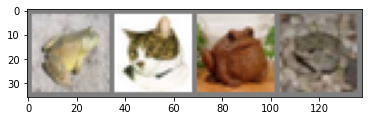

 frog   cat  frog  frog


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #rearrange dimensions to numpy format for disply
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next() #Get one batch (4 here)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batchSize)))

## 3. Define the Architecture of a Convolutional Neural Network

A typical CNN architecture:

![Typical CNN architecture](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)

Let us look at the CNN in detail.

### Convolution layer - with a shared kernel/filter
<center>
<img src="https://www.cs.toronto.edu/~lczhang/360/lec/w04/imgs/math_kernel.png" width="100px" style="margin:0; display:inline">
<img src="https://www.cs.toronto.edu/~lczhang/360/lec/w04/imgs/math_conv.png" width="300px" style="margin:0; display:inline">
</center>

The light blue grid (middle) is the *input* that we are given, e.g., a 5 pixel by 5 pixel greyscale image. The grey grid (left) is a **convolutional kernel/filter** of size $3 \times 3$, containing the *parameters* of this neural network layer.

To compute the output, we superimpose the kernel on a region of the image. 
Let's start at the top left, in the dark blue region. The small numbers in the
bottom right corner of each grid element corresponds to the number in the kernel.
To compute the output at the corresponding location (top left), we "dot" the
pixel intensities in the square region with the kernel. That is, we perform
the computation:

In [6]:
(3 * 0 + 3 * 1 + 2 * 2) + (0 * 2 + 0 * 2 + 1 * 0) + (3 * 0 + 1 * 1 + 2 * 2)

12

The green grid (right) contains the *output* of this convolution layer.
This output is also called an **output feature map**. The terms **feature**,
and **activation** are interchangable. The output value on the top left
of the green grid is consistent with the value we obtained by hand in Python.

To compute the next activation value (say, one to the right of the previous output),
we will shfit the superimposed kernel over by one pixel:

<img src="https://www.cs.toronto.edu/~lczhang/360/lec/w04/imgs/math_conv2.png" width="300px">

The dark blue region is moved to the right by one pixel. We again dot
the pixel intensities in this region with the kernel to get another 12, and continues to get 17, ...

---
### Question 2

Show how we get the value 19 in the output above (in cyan on the right of the figure in this section).

**Answer**: 

---

**Note the shrinked output**: Here, we did not use **zero padding** (at the edges) so the output of this layers is shrinked by 1 on all sides. If the kernel size is $k=2m+1$, the output will be shrinked by $m$ on all sides so the width and height will be both reduced by $2m$.

#### Convolutions with Multiple Input/Output Channels

For a colour image, the kernel will be a **3-dimensional tensor**. This kernel will move through the input features just like before, and we "dot" the pixel intensities with the kernel at each region, exactly like before. This "size of the 3rd (colour) dimension" is called the **number of input channels** or **number of input feature maps**.

We also want to detect multiple features, e.g., both horizontal edges and vertical edges. We would want to learn **many** convolutional filters on the same input. That is,
we would want to make the same computation above using different kernels, like this:

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png" width="200px">

Each circle on the right of the image represents the output of a different kernel dotted
with the highlighted region on the right. So, the output feature is also a 3-dimensional tensor.
The size of the new dimension
is called the **number of output channels** or **number of output feature maps**.
In the picture above, there are 5 output channels.

The `conv2D` layer expects as input a tensor in the format "NCHW", meaning that the dimensions of the tensor should follow the order:

* batch size
* channel
* height
* width

Let us create a convolutional layer using `nn.Conv2d`:

In [7]:
myconv1 = nn.Conv2d(in_channels=3,  # number of input channels
                 out_channels=7, # number of output channels
                 kernel_size=5)  # size of the kernel, 

In [8]:
#Emulate a batch of 32 colour images, each of size 128x128, like this:
x = torch.randn(32, 3, 128, 128)
y = myconv1(x)
y.shape

torch.Size([32, 7, 124, 124])

The output tensor is also in the "NCHW" format. We still have 32 images, and 7 channels
(consistent with `out_channels` of `conv`), and of size 124x124. If we added the appropriate
padding to `conv`, namely `padding` = $m$ (the kernel_size: $2m+1$), then our output width and height should be consistent with the input width and height:

In [9]:
myconv2 = nn.Conv2d(in_channels=3,
                  out_channels=7,
                  kernel_size=5,
                  padding=2)

x = torch.randn(32, 3, 128, 128)
y = myconv2(x)
y.shape

torch.Size([32, 7, 128, 128])

#### The parameters of `Conv2d`

In [10]:
conv_params = list(myconv2.parameters())
print("len(conv_params):", len(conv_params))
print("Filters:", conv_params[0].shape)  #7 filters, each of size 3 x 5 x 5
print("Biases:", conv_params[1].shape)

len(conv_params): 2
Filters: torch.Size([7, 3, 5, 5])
Biases: torch.Size([7])


### Pooling Layers - Subsampling

A pooling layer can be created like this: 
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png" width="300px">

In [11]:
mypool = nn.MaxPool2d(kernel_size=2, stride=2)
y = myconv2(x)
z = mypool(y)
z.shape

torch.Size([32, 7, 64, 64])

Usually, the kernel size and the stride length will be equal so each pixel is pooled only once. 
The pooling layer has **no trainable parameters**:

In [12]:
list(mypool.parameters())

[]

In Lab 6, we did not define a class for our linear regression NN. Here we do so and define a CNN class consisting of several layers as defined below (from the official the Pytorch tutorial).

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3: #input channels; 6: #output channels; 5: kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

myCNN = CNN()

`__init__()` defines the layers.  `forward()` defines the *forward pass* that transform the input to the output. `backward()` is automatically defined using `autograd`. `ReLu()` is the [rectified linear unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), a popular **activation function** that performs a *nonlinear* transformation/mapping of an input variable (element-wise operation). `Conv2d()` defines a convolution layer, as shown below where blue maps indicate inputs, and cyan maps indicate outputs.

<table>
    <tr>
    <td  style="text-align: left"> Convolution with no padding, no strides.      <img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" alt="Drawing" style="width: 250px;"/> </td>
</tr>
</table>

More convolution layers are illustrated nicely at [Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic). 


This network `CNN()` defined above has **two** convolutional layers: `conv1` and `conv2`.

- The first convolutional layer `conv1` requires an input with 3 channels,
  outputs **6 channels**, and has a kernel size of `5x5`. We are not adding any zero-padding.
- The second convolutional layer `conv2` requires an input with **6 channels** (note this **MUST match the output channel number of the previous layer**),  outputs 16 channels, and has a kernel size of (again) `5x5`. We are not adding any zero-padding.

In the `forward` function we see that the convolution operations are always 
followed by the usual ReLU activation function, and a pooling operation.
The pooling operation used is max pooling, so each pooling operation
**reduces the width and height of the neurons in the layer by half**.



Because we are not adding any zero padding, we end up with `16 * 5 * 5` hidden units
after the second convolutional layer (`16` matches the output channel number of `conv2`, `5 * 5` is based on the input dimension `32x32`, see below). These units are then passed to two fully-connected
layers, with the usual ReLU activation in between.

Notice that the number of channels **grew** in later convolutional layers! However,
the number of hidden units in each layer is still reduced because of the convolution and pooling operation:

* Initial Image Size: $3 \times 32 \times 32 $
* After `conv1`: $6 \times 28 \times 28$ ($32 \times 32$ is reduced by `2` on each side)
* After Pooling: $6 \times 14 \times 14 $ (image size halved)
* After `conv2`: $16 \times 10 \times 10$ ($14 \times 14$ is reduced by `2` on each side)
* After Pooling: $16 \times 5 \times 5 $ (halved)
* After `fc1`: $120$
* After `fc2`: $84$
* After `fc3`: $10$ (**= number of classes**)

This pattern of **doubling the number of channels with every pooling / strided convolution**
is common in modern convolutional architectures. It is used to avoid loss of too much information within
a single reduction in resolution.


---
### Question 3

If the input image size is $3 \times 64 \times 64 $, can we use the same CNN defined above? If yes, show the feature sizes after each operation as above. If no, how shall we modify the network architecture to process such $3 \times 64 \times 64 $ images?

**Answer**: 

---

#### Inspect the NN architecture

Now let's take a look at the CNN built. 

In [14]:
print(myCNN)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Let us check the (randomly initialised) parameters of this NN. Below, we check the first 2D convolution. 

In [15]:
params = list(myCNN.parameters())
print(len(params))
print(params[0].size())  # First Conv2d's .weight
print(params[1].size())  # First Conv2d's .bias
print(params[1])

10
torch.Size([6, 3, 5, 5])
torch.Size([6])
Parameter containing:
tensor([-0.0076, -0.0963,  0.1009,  0.0014, -0.1064, -0.0263],
       requires_grad=True)


---
### Question 4

From the above, we can see the length of `params` is 10, i.e. there are 10 sets of parameters. Set 0 is for the weights of `conv1`. Set 1 is the bias of `conv1`. What are the remaining 8 sets for?

**Answer**: 

---

To learn more about these functions, refer to the [`torch.nn` documentation](https://pytorch.org/docs/stable/nn.html) (search for the function, e.g., search for `torch.nn.ReLu` and you will find its documentation [here](https://pytorch.org/docs/stable/nn.html?highlight=relu#torch.nn.ReLU).

## 4. Optimisation, Training and Testing

### Choose a criterion (cross-entropy loss) and an optimizer (SGD with momentum)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myCNN.parameters(), lr=0.001, momentum=0.9)

### Train the network

Next, we will feed data to this CNN to train it, i.e., learn its parameters so that the criterion above (cross-entropy loss) is minimised, using the SGD optimiser. The dataset is loaded in batches to train the model. One `epoch` means one cycle through the full training dataset.  The steps are 
* Define the optimisation criterion and optimisation method.
* Iterate through the whole dataset in batches, for a number of `epochs` till a maximum specified or a convergence criteria (e.g., successive change of loss < 0.000001)
* In each batch processing, we 
    * do a forward pass
    * compute the loss
    * backpropagate the loss via `autograd`
    * update the parameters

Now, we loop over our data iterator, and feed the inputs to the network and optimize. Here, I set `max_epochs` to 2 for quick testing. In practice, more epochs typically lead to better performance. 

In [17]:
max_epochs=2
for epoch in range(max_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = myCNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training!')

[1,  2000] loss: 2.224
[1,  4000] loss: 1.870
[1,  6000] loss: 1.661
[1,  8000] loss: 1.580
[1, 10000] loss: 1.520
[1, 12000] loss: 1.453
[2,  2000] loss: 1.402
[2,  4000] loss: 1.375
[2,  6000] loss: 1.358
[2,  8000] loss: 1.338
[2, 10000] loss: 1.326
[2, 12000] loss: 1.291
Finished Training!


Take a look at how `autograd` keeps track of the gradients for back propagation.

In [18]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])

### Save our trained model:

In [19]:
PATH = 'data/cifar_net.pth'
torch.save(myCNN.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### Test the network on the test data

We will test the trained network by predicting the class label that the neural network outputs, and checking it against the ground-truth. Okay, first step. Let us display an image from the test set to get familiar.

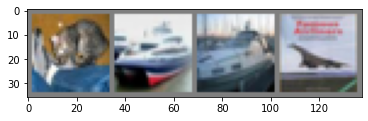

GroundTruth:    cat  ship  ship plane


In [20]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batchSize)))

Next, let's load back in our saved model (note: saving and re-loading wasn't necessary here, we only did it for illustration):



In [21]:
loadCNN = CNN()
loadCNN.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [22]:
outputs = loadCNN(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [23]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batchSize)))

Predicted:    cat  ship  ship  ship


How accurate do you get? 

---

### Question 5

Note that the results are *random* because the batches are randomly formed. How to fix the randomness so that you can get the same results if you run your code multiple times? 

**Answer**: 

---


Let us look at how the network performs on the whole dataset.

In [24]:
correct = 0
total = 0
with torch.no_grad():  #testing phase, no need to compute the gradients to save time
    for data in testloader:
        images, labels = data
        outputs = loadCNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


You should get something around 50%. 

---
### Question 6

What is the **chance level** accuracy (i.e. random classification)? How good is your CNN accuracy compared to the chance level?

**Answer**: 

---

If your network works better than chance, it seems like to have learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = loadCNN(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batchSize):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 56 %
Accuracy of  bird : 45 %
Accuracy of   cat : 37 %
Accuracy of  deer : 38 %
Accuracy of   dog : 36 %
Accuracy of  frog : 65 %
Accuracy of horse : 76 %
Accuracy of  ship : 74 %
Accuracy of truck : 51 %


---
### Question 7

Run a [digits domain adaption / transfer learning example in Google Colab](https://colab.research.google.com/github/pykale/pykale/blob/main/examples/digits_dann_lightn/tutorial.ipynb) using the default hardware (CPU) and then using GPU (see the instruction in the notebook) to compare the difference in running time. Increase to max 10 epochs or more to see the difference again.



## Additional ideas to explore

* Change the [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) to different choices and compare the results.
* Train the network for more passes (epochs) and/or other training settings (e.g., other patch sizes) to study performance variations.
* Practice change the CNN architecture (pay attention to the size matching between different layers).
* Try on GPU if you have one by following the end of the [the CIFAR10 Pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py).
* Try out the AlexNet `torchvision.models.alexnet` and other architectures from `torchvision.models` for image classification
* Try out other pytorch computer vision datasets `torchvision.datasets` for image classification. 